# code by Tae Hwan Jung(Jeff Jung) @graykode
# Reference : https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/LSTM_Attn.py

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 모델 설계

In [6]:
class BiLSTM_Attention(nn.Module):#신경망모듈 기본 클래스
    # ^ Pytorch Module내에 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Module 클레스를 상속받는 Net클래스를 정의.
    def __init__(self): 
        super(BiLSTM_Attention, self).__init__() #클래스 초기화(bound super object; requires isinstance(obj, type))
        self.embedding = nn.Embedding(vocab_size, embedding_dim) #사전의 크기, 임배딩 벡터의 크기
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True) #LSTM(임배딩 벡터의 크기, 은닉층 사이즈 ,양방향 LSTM)
        self.out = nn.Linear(n_hidden * 2, num_classes)#선형변환(은닉유닛 사이즈*2[입력 샘플 크기], 출력 샘플 크기)

    # v lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, lstm_output, final_state): #어탠션 망 함수(self, lstm_output, 최종상태)
        #print("lstm_output : ", lstm_output.size()) #6단 3행 10열
        #print("final_state : ", final_state.size()) #2단 6행 5열
        hidden = final_state.view(-1, n_hidden * 2, 1) 
        # 양식에 맞게 변환, hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        #print("hidden : ", hidden.size()) #6단 10행 1열
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # 행렬 곱 수행, attn_weights : [batch_size, n_step]
        #print("attn_weights : ", attn_weights.size()) #6행3열
        soft_attn_weights = F.softmax(attn_weights, 1) # 계산할 깊이가 2, (input(tensor), dim)
        #print("softmax : ", soft_attn_weights) #6행3열
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        #print(lstm_output)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        # transpose(차원 전치), 차원을 늘리고 3(unsqueeze), 차원을 줄임 3(squeeze)
        return context, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
                                            #tensor를 numpy로 반환
    def forward(self, X):
        input = self.embedding(X) # input : [batch_size, len_seq, embedding_dim]
        #print("input1 : ", input) # 6단 3행 2열
        input = input.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim](원하는 차원의 순서 변환, 1,0,2)
        #print("input2 : ", input) #3단 6행 2열 
        hidden_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden], 2단 6행 5열
        cell_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        #print("len(x) : ", len(X)) 결과:6
        
        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state)) 
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.out(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

# 준비 및 전처리

In [3]:
if __name__ == '__main__':  # 프로그램의 시작점
    embedding_dim = 2 # embedding size
    n_hidden = 5  # number of hidden units in one cell
    num_classes = 2  # 0 or 1

    # 3 words sentences (=sequence_length is 3)
    sentences = ["i love you", "he loves me", "she likes football", "i hate you", "sorry for that", "this is awful"]
    labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

    word_list = " ".join(sentences).split() # join = 리스트에서 문자열로 토큰화
    word_list = list(set(word_list)) # set = 집합선언
    word_dict = {w: i for i, w in enumerate(word_list)} # 딕셔너리 선언, 몇번째 반복인지 확인
    print("word_dic : ", word_dict) # ex) i:0, love:2....15
    vocab_size = len(word_dict)  # dict의 길이

    model = BiLSTM_Attention()   #모델 지정

    criterion = nn.CrossEntropyLoss()
    ''' 
    ^ loss 계산, corssentropy = C 클래스 로 분류 문제를 훈련 할 때 유용합니다 . 
    제공되는 경우 선택적 인수 weight는 각 클래스에 가중치를 할당 하는 1D Tensor 여야합니다 .
    
    이 모델의 output값과 계산될 Label값은 Class를 표현하는 원-핫 인코딩 값임.
    모델의 output한 값과 원-핫 인코딩 결과의 Loss는 CrossEntropy를 이용하여 계산하기 위함.
    '''
    optimizer = optim.Adam(model.parameters(), lr=0.001) # 매개변수 최적화(model.parameters()), 아담
    '''
    ^ Back propagation을 통해 파라미터를 업데이트 할때 이용하는 Optimizer를 정의
    '''
    inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])
    #print("inputs : ", inputs.size()) #6행 3열
    # ^ asarray는 ndarray(다차원 행렬 구조)로 타입 변경, ndarray는 기존 파이썬과는 다르게 오직 같은 종류의 데이터만을 배열에 담을 수 있다.
    targets = torch.LongTensor([out for out in labels])  # To using Torch Softmax Loss function
    #print(targets) 1행 6열
    #텐서에는 자료형이라는 것이 있습니다. 각 데이터형별로 정의되어져 있는데, 64비트의 부호 있는 정수는 torch.LongTensor를 사용합니다. 

word_dic :  {'likes': 0, 'hate': 1, 'you': 2, 'me': 3, 'love': 4, 'sorry': 5, 'football': 6, 'i': 7, 'awful': 8, 'he': 9, 'loves': 10, 'this': 11, 'she': 12, 'is': 13, 'for': 14, 'that': 15}


# Training

In [4]:
    for epoch in range(5000):
        optimizer.zero_grad()  # 최적화된 그레디언트 값을 0으로 반환
        ''' 
        ^ 기존에 정의한 장비에 단어 데이터와 레이블 데이터를 할당할 경우, 
        과거에 이용한 mini-batch내에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss의 Gradient값이 Optimizer에 할당돼 있으므로 
        optimizer의 Gradient를 초기화 함.
        '''
        output, attention = model(inputs)
        loss = criterion(output, targets)
        
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()   # 역전파
        ''' 
        ^ 계산된 loss 값에 대해 backward() 매서드를 이용하면 각 파라미터 값에 대해 Gradient를 계산하고
        이를 통해 Back Progpagation을 진행한다는 것을 의미
        '''
        optimizer.step()   # 단일 최적화 단계 수행    
        '''
        ^ Loss값을 계산한 결과를 바탕으로 각 파라미터에 할당된 Gradient값을 이용해 파라미터 값을 업데이트.
        '''

Epoch: 1000 cost = 0.002880
Epoch: 2000 cost = 0.000591
Epoch: 3000 cost = 0.000231
Epoch: 4000 cost = 0.000111
Epoch: 5000 cost = 0.000059


# Test & Predict

sorry hate you is Bad Mean...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


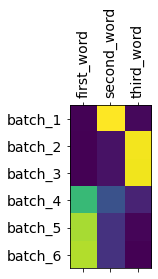

In [5]:
# v Test 자료 준비 
    test_text = 'sorry hate you'
    #test_text='sorry loves you'
    tests = [np.asarray([word_dict[n] for n in test_text.split()])]
    #print("tests : ", tests) #[array([12,10,2])]
    test_batch = torch.LongTensor(tests)
    #print("test_batch :", test_batch.size()) #tensor([1,3])

# Predict
    predict, _ = model(test_batch)
    predict = predict.data.max(1, keepdim=True)[1] # 텐서의 최대값 반환, 1차원으로 줄여야할 차원이 있는가?
    if predict[0][0] == 0:
        print(test_text,"is Bad Mean...")
    else:
        print(test_text,"is Good Mean!!")

    fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
    plt.show()